In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [83]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


In [4]:
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection5_materials/'
data = pd.read_csv(parent_path + 'churn_data.csv')

target = 'Exited'

In [82]:
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


# commons

In [5]:
def compare_metrics(X, y, *pipelines, beta=1):
  metrics = []
  metric_names = ['model' , 'best threshold', 'precision', 'recall', 'f-score', 'roc auc']
  for pipeline in pipelines:
    pred_proba = pipeline.predict_proba(X)[:, 1]
    
    roc_auc = roc_auc_score(y, pred_proba)
    precisions, recalls, thresholds = precision_recall_curve(y, pred_proba)
    fscores = (1 + beta ** 2) * (precisions * recalls) / ((beta ** 2) * precisions + recalls)
    ix = fscores.argmax()
    metrics.append([pipeline.named_steps['fit'].__class__.__name__, thresholds[ix], precisions[ix], recalls[ix], fscores[ix], roc_auc])
  return pd.DataFrame(metrics, columns=metric_names)

In [ ]:
# зависимость экономической целесообразности модели от соотношения ожидаемой прибыли с каждого удержанного и стоимости удержания клиента
def ef_dependency(cf, max_ratio=4):
  x = np.linspace(0, max_ratio, 150)   # profit_retention_ratio = 4 означает, что предполагаемая прибыль в 4 раза выше стоимости удержания
  y = ef(cf, x)
  minimal_ratio = 1 / (cf[0, 0] /  cf[0].sum())

  plt.title('Зависимость экономической целесообразности модели от соотношения ожидаемой прибыли с каждого удержанного клиента и стоимости его удержания')
  plt.plot(x, y)
  plt.plot([minimal_ratio] * 2, [0, y.max()], color='r', label=f'minimal ratio ({round(minimal_ratio, 4)})')
  plt.xlabel('profit / retention ratio')
  plt.ylabel('economical feasibility')
  plt.legend()
  plt.show()

In [ ]:
def economical_feasibility(cf, *, retention, profit):
  """ Отношение предполагаемых доходов от удержанных клиентов к расходам на их удержание для модели оттока
      Если > 1, то при использовании модели есть положительный экономический эффект (и это ничего не говорит о его величине)
  retention - стоимость удержания клиента
  profit - ожидаемая прибыль с каждого удержанного клиента
  """
  # затраты на удержание клиентов, идентифицированных как "отток"
  expenses = retention * cf[0].sum()
  # ожидаемая прибыль с удержанных клиентов
  earnings = cf[0, 0] * profit
  return earnings / expenses


def ef(cf, profit_retention_ratio):
  """ То же, что и economical_feasibility(), но с другим аргументом
  profit_retention_ratio - соотношение ожидаемой прибыли с каждого удержанного и стоимости удержания клиента
  """
  return (cf[0, 0] /  cf[0].sum()) * (profit_retention_ratio)

# featuring

In [6]:
class EncodeOneHots(BaseEstimator, TransformerMixin):
  def __init__(self, on=[]):
    self.on = on

  def fit(self, X, y=None):
    # self.features = list(set(self.features) & set(X.columns))     # columns intersection to drop non-exists
    return self

  def transform(self, X, y=None):
    return pd.get_dummies(X, columns=self.on)

In [7]:
class DataScaler(BaseEstimator, TransformerMixin):
  def __init__(self, scaler, scale=[], keep=[], keepsuffix=[]):
    self.scaler = scaler()
    self.scale = scale
    self.keep = keep
    self.keepsuffix = keepsuffix
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    df = X.copy()
    if self.keep:
      columns = [col for col in df.columns if col not in self.keep]
    elif not self.scale:
      columns = df.columns
    else:      
      columns = [col for col in self.scale if col in df.columns]
    
    columns = [col for col in columns if not any([col.startswith(suff) for suff in self.keepsuffix])]

    self.scaler.fit(df[columns])
    df[columns] = self.scaler.transform(df[columns])
    return df

In [8]:
class DropColumns(BaseEstimator, TransformerMixin):
  def __init__(self, drop=[], leave=[]):
    self.drop = drop
    self.leave = leave   

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.leave:
      return X[self.leave]
    elif self.drop:
      return X.drop(columns=self.drop)
    else:
      return X

# modeling

In [145]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(target, axis=1), data[target], test_size=0.3, random_state=0)

categories = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname', ]

prepare_pipeline = Pipeline([('categorical one hots', EncodeOneHots(on=categories)),
                             ('drop', DropColumns(drop=cols_to_drop))
                             ])

In [146]:
# SGD
sgd_pipeline = Pipeline([('prepare', prepare_pipeline),
                         ('scale', DataScaler(MinMaxScaler, keep=categories)),
                         ('fit', SGDClassifier(n_jobs=-1, random_state=19,
                                               penalty='l1',
                                               loss='log',
                                              #  learning_rate='adaptive', eta0=0.1,
                                              #  class_weight='balanced',
                                               ))
                         ])
sgd_pipeline.fit(X_train, y_train);

In [147]:
# LGBM
lgbm_pipeline = Pipeline([('prepare', prepare_pipeline),
                          ('fit', LGBMClassifier(n_jobs=-1, random_state=19,
                                                 class_weight='balanced',
                                                #  max_depth=6,
                                                 ))
                          ])
lgbm_pipeline.fit(X_train, y_train);

In [148]:
# RF
rf_pipeline = Pipeline([('prepare', prepare_pipeline),
                        ('fit', RandomForestClassifier(n_jobs=-1, random_state=19,
                                                      #  n_estimators=10,
                                                       max_depth=7,
                                                       ))
                        ])
rf_pipeline.fit(X_train, y_train);

Если стоимость удержания клиента очень высока, а привлечения нового - низка, то нет необходимости отлавливать весь отток и можно сделать упор в сторону precision, и удерживать только наиболее важных клиентов, среди найденных.

Если же наоборот, привлечь нового клиента дороже, чем удержать имебщегося, то лучше определить всех "утекающих" клиентов, максимизируя recall.

Для балансировки precision/recall используется параметр `beta` (аналогично F-beta score).

In [149]:
compare_metrics(X_train, y_train, sgd_pipeline, lgbm_pipeline, rf_pipeline, beta=1)

,model,best threshold,precision,recall,f-score,roc auc
0,SGDClassifier,0.274680,0.415565,0.599576,0.490893,0.762724
1,LGBMClassifier,0.594361,0.773222,0.852401,0.810883,0.969741
2,RandomForestClassifier,0.263070,0.622919,0.687147,0.653459,0.885421


In [150]:
metrics_df = compare_metrics(X_valid, y_valid, sgd_pipeline, lgbm_pipeline, rf_pipeline, beta=1)
metrics_df

,model,best threshold,precision,recall,f-score,roc auc
0,SGDClassifier,0.276278,0.464332,0.576490,0.514368,0.767711
1,LGBMClassifier,0.603803,0.618907,0.674718,0.645609,0.871596
2,RandomForestClassifier,0.309960,0.664348,0.615137,0.638796,0.866982


# economics

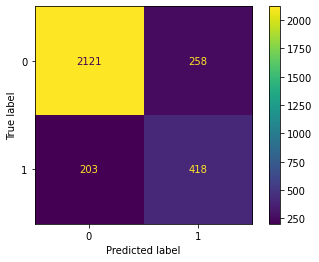

In [111]:
threshold = metrics_df.loc[1, 'best threshold']
predicts = lgbm_pipeline.predict_proba(X_valid)[:, 1] > threshold

ConfusionMatrixDisplay.from_predictions(y_valid, predicts);

In [112]:
# True Positive:  клиенты, уходящие в отток
# False Negative: клиенты, уходящие в отток, которых модель не заметила
# False Positive: неверно замеченные клиенты. На них зря потратили бюджет - они никуда не собирались уходить
# True Negative:  исходно лояльные клиенты

# 2121 ушедших в отток и 418 не ушедших успешно идентифицированы
# 258 ошибочно сочтены ушедшими, 203 ушедших проморгали

In [113]:
# ушедшие пользователи - их можно как-то категоризировать, аггрегировать и вообще что угодно делать
outflow = X_valid[(y_valid == 1) & ((predicts > threshold) == 0)]
outflow.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
898,899,15654700,Fallaci,523,France,Female,40,2,102967.41,1,1,0,128702.10
2670,2671,15760446,Pagnotto,598,France,Female,64,9,0.00,1,0,1,13181.37
4429,4430,15686463,Fu,626,France,Male,38,7,141074.59,1,1,0,52795.56


In [115]:
retention = 1   # стоимость удержания клиента
profit = 2      # ожидаемая прибыль с каждого удержанного клиента

cf = confusion_matrix(y_valid, predicts)
economical_feasibility(cf, retention=1, profit=2)

1.7831021437578816

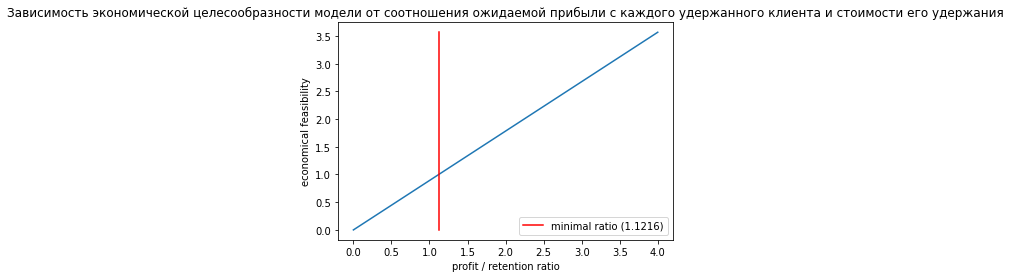

In [308]:
ef_dependency(cf)

Для данной модели целесообразный порог соотношения `profit/retention` равен `1.1216`.

Это означает, что для положительного экономического эффекта применения модели ожидаемая прибыль с возвращенного клиента должна превышать затраты на его возвращение более чем в `1.1216` раз.

# LGBM hyperparameters

In [359]:
params = {
    'learning_rate': 0.05,
    'min_child_samples': 3,
    'n_estimators': 150,
    'boosting_type': 'dart',   # 'gbdt' / 'dart' / 'goss' / 'rf'
    # 'subsample': 0.7
}

In [360]:
# LGBM
best_pipeline = Pipeline([('prepare', prepare_pipeline),
                          ('fit', LGBMClassifier(n_jobs=-1, random_state=19,
                                                 class_weight='balanced',
                                                 **params
                                                 ))
                          ])
best_pipeline.fit(X_train, y_train);
best_metrics = compare_metrics(X_valid, y_valid, lgbm_pipeline, best_pipeline, beta=1)
best_metrics

,model,best threshold,precision,recall,f-score,roc auc
0,LGBMClassifier,0.603803,0.618907,0.674718,0.645609,0.871596
1,LGBMClassifier,0.650238,0.666107,0.639291,0.652424,0.877229


# RF hyperparameters

In [364]:
params = {
    # 'max_depth': 10,
    'min_samples_leaf': 5,
    'n_estimators': 200,    
}

In [365]:
# RandomForest
best_pipeline = Pipeline([('prepare', prepare_pipeline),
                          ('fit', RandomForestClassifier(n_jobs=-1, random_state=19,
                                                         class_weight='balanced',
                                                         **params
                                                         ))
                          ])
best_pipeline.fit(X_train, y_train);
best_metrics = compare_metrics(X_valid, y_valid, rf_pipeline, best_pipeline, beta=1)
best_metrics

,model,best threshold,precision,recall,f-score,roc auc
0,RandomForestClassifier,0.309960,0.664348,0.615137,0.638796,0.866982
1,RandomForestClassifier,0.563539,0.682624,0.619968,0.649789,0.872644


# economics 2

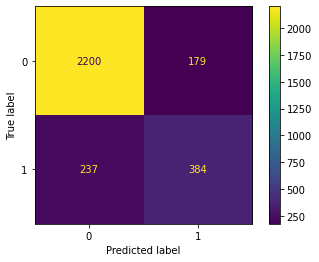

In [366]:
threshold = best_metrics.loc[1, 'best threshold']
predicts = best_pipeline.predict_proba(X_valid)[:, 1] > threshold

ConfusionMatrixDisplay.from_predictions(y_valid, predicts);

In [372]:
retention = 1   # стоимость удержания клиента
profit = 2      # ожидаемая прибыль с каждого удержанного клиента

cf = confusion_matrix(y_valid, predicts)
economical_feasibility(cf, retention=1, profit=2)

1.8495166036149642

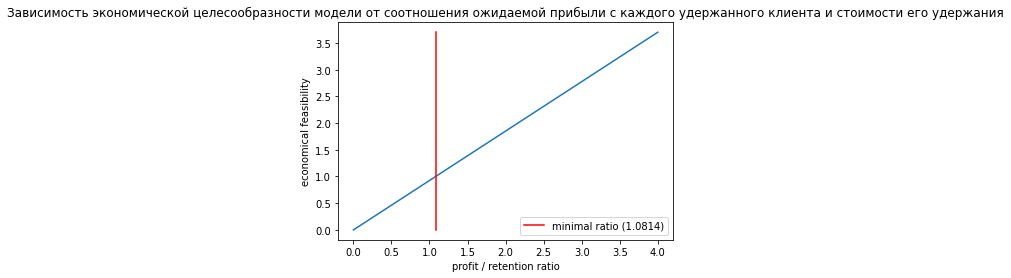

In [371]:
ef_dependency(cf)

Несмотря на то, что метрики LGBM чуть выше, чем RF, экономический эффект от RF-модели выше (хоть и всего на 0,9%)